In [1]:
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import numpy as np
from qiskit import transpile
from qiskit.quantum_info import Kraus, SuperOp, Operator
from qiskit.extensions import RYGate
from qiskit.providers.aer import AerSimulator
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
import scipy.optimize as opt
import statistics
import math
%matplotlib inline
import matplotlib.pyplot as plt

[2.1469442593585278e-08, 2.3371823037007326e-07, 8.770650861175064e-08, 4.1533757453391234e-07, 1.7588228544132115e-07, 1.3523433975315947e-08, 1.121167811783014e-07, 4.7950032908195244e-08, 1.6922628607586616e-07, 1.2669503625465747e-07, 5.247308453912497e-09, 1.2109649076832945e-08, 3.129214102514372e-08, 2.6396858494731727e-08, 5.716476244108552e-08, 8.639404414311748e-08, 3.56566465903141e-07, 1.4984733996628064e-07, 8.696379738715816e-08, 5.261948379247761e-07, 3.9076265679142163e-08, 3.616241945356581e-08, 1.4672998268469539e-08, 7.815897406750797e-08, 2.1171357593073685e-08, 3.9669996352620527e-08, 6.154863527485822e-09, 2.2296140851735479e-07, 2.1170898205956203e-07, 6.46984814605967e-07, 1.0225386470660263e-07, 3.979401043168891e-08, 2.8416422438502667e-08, 9.930140991137547e-08, 5.3231704608992127e-08, 3.5660377456306773e-07, 1.1419117569758521e-07, 2.1604391897938803e-07, 6.736315878904675e-08, 2.707260005550388e-08, 3.499225071618689e-07, 9.154494156781079e-08, 2.3043367578

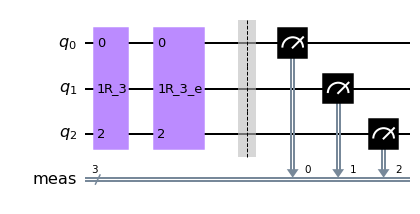

In [15]:
clt_opt_results_e_s=[]
ave_sq_error_e_s=[]
ex_it=100
for r in range(ex_it):
    a=0.2
    p=0.9
    pi=np.pi
    theta=np.arcsin(np.sqrt(a))
    opt_results_e_s=[]
    n0=[]
    n1=[]
    n2=[]
    theta_0=[pi/4]
    Ng=[]
    m=[]
    qlist=[]
    it=2
    N=40000
    n=3
    amf=50
    for q in range(n):
        qlist.append(q)
    d=2**n
    N0='0'*n
    N1='1'*n
    for k in range(amf):
        Ng.append(2*k+1)
        m.append(k+1)
        n0.append([])
        n1.append([])
        n2.append([])
        R_1=[np.cos(Ng[k]*theta),-np.sin(Ng[k]*theta)]
        R_2=[np.sin(Ng[k]*theta),np.cos(Ng[k]*theta)]
        R_1[1:1]=[0]*(d-2)
        R_2[1:1]=[0]*(d-2)
        R_n=[R_1,R_2]
        for e in range(d-2):
            Z=[0]*(d-1)
            Z.insert(e+1,1)
            R_n.insert(-1,Z)
        R_en_n=Operator(R_n)
        for i in range(it):
            theta_e=Ng[k]*theta_0[i+k*it]+pi/4
            R_1e=[np.cos(-theta_e),-np.sin(-theta_e)]
            R_2e=[np.sin(-theta_e),np.cos(-theta_e)]
            R_1e[1:1]=[0]*(d-2)
            R_2e[1:1]=[0]*(d-2)
            R_ne=[R_1e,R_2e]
            for f in range(d-2):
                Ze=[0]*(d-1)
                Ze.insert(f+1,1)
                R_ne.insert(-1,Ze)
            R_en_ne=Operator(R_ne)
            circ_e_n=QuantumCircuit(n)
            circ_e_n.unitary(R_en_n,qlist,label='R_3')
            circ_e_n.unitary(R_en_ne,qlist,label='R_3_e')
            circ_e_n.measure_all()
            # Create an empty noise model
            noise_depolarizing = NoiseModel()
            noise_depolarizing.add_basis_gates(['unitary'])
            # Add depolarizing error to all single qubit u1, u2, u3 gates
            error = depolarizing_error(1-p**m[k], n)
            noise_depolarizing.add_all_qubit_quantum_error(error, 'R_3')
            # Create noisy simulator backend
            sim_noise = AerSimulator(noise_model=noise_depolarizing)
            # Transpile circuit for noisy basis gates
            circ_e_n_tnoise = transpile(circ_e_n, sim_noise)
            # Run and get counts
            if i==0:
                s=np.sqrt(N)
                result_noise = sim_noise.run(circ_e_n_tnoise,shots=s).result()
            else:
                s=N-np.sqrt(N)
                result_noise = sim_noise.run(circ_e_n_tnoise,shots=s).result()
            counts_noise = result_noise.get_counts(0)
            n0[k].append(counts_noise[N0])
            n1[k].append(counts_noise[N1])
            n2[k].append(s-n0[k][i]-n1[k][i])
            def func(x):
                ans=0
                for l in range(k+1):
                    for j in range(i+1):
                        angle=x[0]-theta_0[j+l*it]
                        ans+=np.log((p**m[l])*(1+np.sin(2*Ng[l]*angle))/2+(1-p**m[l])/d)*n0[l][j]
                        ans+=np.log((p**m[l])*(1-np.sin(2*Ng[l]*angle))/2+(1-p**m[l])/d)*n1[l][j]
                        ans+=np.log((d-2)*(1-p**m[l])/d)*n2[l][j]
                return -ans
            x=opt.brute(func,[(0,pi/2)])
            opt_results_e_s.append(np.sin(x[0])**2)
            theta_0.append(x[0])
    ave_sq_error_e_s.append(sum((opt_results_e_s[2*n+1]-a)**2 for n in range(int(len(opt_results_e_s)/2)))*2/len(opt_results_e_s))
    clt_opt_results_e_s.append(opt_results_e_s)
print(ave_sq_error_e_s)
circ_e_n.draw('mpl')

[6.059379138842696e-07, 3.4612071659092005e-08, 7.63245515205338e-07, 2.8011113008656622e-08, 5.673868040189581e-08, 8.346676616085678e-07, 1.3238626850261564e-07, 9.097892561563178e-07, 9.963373102615707e-07, 3.679882324039462e-08, 7.464060761859054e-07, 3.0506077467905277e-07, 2.905597709107174e-08, 2.5994296174449334e-07, 1.1042649297784577e-06, 2.2108077963459005e-07, 2.4256794252469698e-08, 4.672286841326072e-07, 2.902470088281871e-07, 2.745779269663757e-07, 1.3538823393861475e-07, 8.865987170246354e-07, 8.432523960558843e-08, 5.682725808488129e-07, 1.0474117915805097e-07, 3.3844878863223785e-07, 1.0023801982120872e-07, 2.8714280631824572e-06, 1.5872168715544196e-06, 9.699175470221719e-08, 1.0102258375236911e-07, 7.139750851980291e-07, 4.001206953420985e-08, 9.279195926951224e-07, 2.7483862176850234e-08, 4.776619899780913e-07, 2.9735226138997746e-07, 1.2635659063618544e-08, 8.709370253436438e-07, 1.9050113400229964e-07, 6.583233293701973e-08, 1.0551117624465172e-06, 9.448706217209

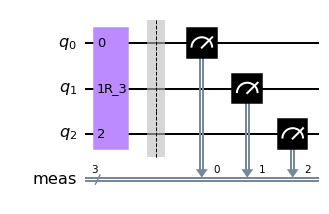

In [16]:
clt_opt_results_c=[]
ave_sq_error_c=[]
ex_it=100
for r in range(ex_it):
    a=0.2
    p=0.9
    pi=np.pi
    theta=np.arcsin(np.sqrt(a))
    opt_results_c=[]
    n0=[]
    n1=[]
    n2=[]
    Ng=[]
    m=[]
    qlist=[]
    it=1
    N=40000
    s=N-np.sqrt(N)
    n=3
    amf=50
    for q in range(n):
        qlist.append(q)
    d=2**n
    N0='0'*n
    for k in range(amf):
        Ng.append(2*k+1)
        m.append(k+1)
        n0.append([])
        n1.append([])
        n2.append([])
        R_1=[np.cos(Ng[k]*theta),-np.sin(Ng[k]*theta)]
        R_2=[np.sin(Ng[k]*theta),np.cos(Ng[k]*theta)]
        R_1[1:1]=[0]*(d-2)
        R_2[1:1]=[0]*(d-2)
        R_n=[R_1,R_2]
        for e in range(d-2):
            Z=[0]*(d-1)
            Z.insert(e+1,1)
            R_n.insert(-1,Z)
        R_en_n=Operator(R_n)
        for i in range(it):
            circ_c_n=QuantumCircuit(n)
            circ_c_n.unitary(R_en_n,qlist,label='R_3')
            circ_c_n.measure_all()
            # Create an empty noise model
            noise_depolarizing = NoiseModel()
            noise_depolarizing.add_basis_gates(['unitary'])
            # Add depolarizing error to all single qubit u1, u2, u3 gates
            error = depolarizing_error(1-p**m[k], n)
            noise_depolarizing.add_all_qubit_quantum_error(error, 'R_3')
            # Create noisy simulator backend
            sim_noise = AerSimulator(noise_model=noise_depolarizing)
            # Transpile circuit for noisy basis gates
            circ_c_n_tnoise = transpile(circ_c_n, sim_noise)
            # Run and get counts
            result_noise = sim_noise.run(circ_c_n_tnoise,shots=s).result()
            counts_noise = result_noise.get_counts(0)
            n0[k].append(counts_noise[N0])
            n1[k].append(N-n0[k][i])
            def func(x):
                ans=0
                for l in range(k+1):
                    for j in range(i+1):
                        angle=x[0]
                        ans+=np.log((p**m[l])*(np.cos(Ng[l]*angle)**2)+(1-p**m[l])/d)*n0[l][j]
                        ans+=np.log((p**m[l])*(np.sin(Ng[l]*angle)**2)+((d-1)*(1-p**m[l]))/d)*n1[l][j]
                return -ans
            x=opt.brute(func,[(0,pi/2)])
            opt_results_c.append(np.sin(x[0])**2)
    ave_sq_error_c.append(sum((n-a)**2 for n in opt_results_c)/len(opt_results_c))
    clt_opt_results_c.append(opt_results_c)
print(ave_sq_error_c)
circ_c_n.draw('mpl')

[1.2877983792526574e-07, 1.0286435018353923e-07, 2.1338333123841644e-07, 9.323418798118804e-08, 1.5938637919181383e-07, 3.4321507203073654e-08, 3.605976238465132e-08, 1.717813798390289e-07, 7.35894016915637e-08, 1.3137168988928703e-07, 1.8341854276190276e-07, 5.780949520077369e-08, 9.214483469801239e-07, 1.558138619775896e-07, 6.422072512348789e-08, 4.5983266685547645e-08, 5.371322530454794e-07, 3.3943986584623184e-08, 3.5468482393525193e-07, 7.017493618116356e-08, 1.4221932653868559e-08, 4.549422604781021e-08, 3.80868153124009e-08, 8.834461787413754e-08, 1.19763440337078e-07, 6.05507403536348e-08, 5.093980876331202e-07, 2.671636790122216e-07, 5.353519701343671e-07, 3.712332084053364e-07, 2.259306449521784e-07, 4.416493122133108e-07, 4.1554204631292503e-07, 9.200018255071093e-08, 1.4145579404190242e-07, 4.2305947701495774e-08, 3.862980756597853e-08, 7.720141021137294e-08, 9.832681793393652e-08, 5.774875632327291e-08, 3.077751690756783e-08, 1.1096218518092713e-07, 4.140702111502548e-08,

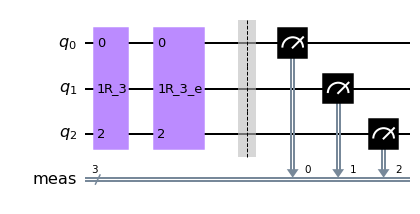

In [17]:
clt_opt_results_e=[]
ave_sq_error_e=[]
ex_it=100
for r in range(ex_it):
    a=0.2
    p=0.9
    pi=np.pi
    theta=np.arcsin(np.sqrt(a))
    opt_results_e=[]
    n0=[]
    n1=[]
    n2=[]
    theta_0=[pi/4]
    Ng=[]
    m=[]
    qlist=[]
    it=2
    N=40000
    s=int((N-np.sqrt(N))/2)
    n=3
    amf=50
    for q in range(n):
        qlist.append(q)
    d=2**n
    N0='0'*n
    N1='1'*n
    for k in range(amf):
        Ng.append(2*k+1)
        m.append(k+1)
        n0.append([])
        n1.append([])
        n2.append([])
        R_1=[np.cos(Ng[k]*theta),-np.sin(Ng[k]*theta)]
        R_2=[np.sin(Ng[k]*theta),np.cos(Ng[k]*theta)]
        R_1[1:1]=[0]*(d-2)
        R_2[1:1]=[0]*(d-2)
        R_n=[R_1,R_2]
        for e in range(d-2):
            Z=[0]*(d-1)
            Z.insert(e+1,1)
            R_n.insert(-1,Z)
        R_en_n=Operator(R_n)
        for i in range(it):
            theta_e=Ng[k]*theta_0[i+k*it]+pi/4
            R_1e=[np.cos(-theta_e),-np.sin(-theta_e)]
            R_2e=[np.sin(-theta_e),np.cos(-theta_e)]
            R_1e[1:1]=[0]*(d-2)
            R_2e[1:1]=[0]*(d-2)
            R_ne=[R_1e,R_2e]
            for f in range(d-2):
                Ze=[0]*(d-1)
                Ze.insert(f+1,1)
                R_ne.insert(-1,Ze)
            R_en_ne=Operator(R_ne)
            circ_e_n=QuantumCircuit(n)
            circ_e_n.unitary(R_en_n,qlist,label='R_3')
            circ_e_n.unitary(R_en_ne,qlist,label='R_3_e')
            circ_e_n.measure_all()
            # Create an empty noise model
            noise_depolarizing = NoiseModel()
            noise_depolarizing.add_basis_gates(['unitary'])
            # Add depolarizing error to all single qubit u1, u2, u3 gates
            error = depolarizing_error(1-p**m[k], n)
            noise_depolarizing.add_all_qubit_quantum_error(error, 'R_3_e')
            # Create noisy simulator backend
            sim_noise = AerSimulator(noise_model=noise_depolarizing)
            # Transpile circuit for noisy basis gates
            circ_e_n_tnoise = transpile(circ_e_n, sim_noise)
            # Run and get counts
            result_noise = sim_noise.run(circ_e_n_tnoise,shots=s).result()
            counts_noise = result_noise.get_counts(0)
            n0[k].append(counts_noise[N0])
            n1[k].append(counts_noise[N1])
            n2[k].append(N-n0[k][i]-n1[k][i])
            def func(x):
                ans=0
                for l in range(k+1):
                    for j in range(i+1):
                        angle=x[0]-theta_0[j+l*it]
                        ans+=np.log((p**m[l])*(1+np.sin(2*Ng[l]*angle))/2+(1-p**m[l])/d)*n0[l][j]
                        ans+=np.log((p**m[l])*(1-np.sin(2*Ng[l]*angle))/2+(1-p**m[l])/d)*n1[l][j]
                        ans+=np.log((d-2)*(1-p**m[l])/d)*n2[l][j]
                return -ans
            x=opt.brute(func,[(0,pi/2)])
            opt_results_e.append(np.sin(x[0])**2)
            theta_0.append(x[0])
    ave_sq_error_e.append(sum((n-a)**2 for n in opt_results_e)/len(opt_results_e))
    clt_opt_results_e.append(opt_results_e)
print(ave_sq_error_e)
circ_e_n.draw('mpl')

In [8]:
SLD=[(Ng[n]**2*d*p**(2*m[n]))/((2+(d-2)*p**m[n])*(a*(1-a))) for n in range(amf)]
SLD_sum=1/((N-np.sqrt(N))*sum(SLD))
ave_sq_error_ideal=[SLD_sum]*10
print(ave_sq_error_ideal)

[2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09, 2.2197708039855873e-09]


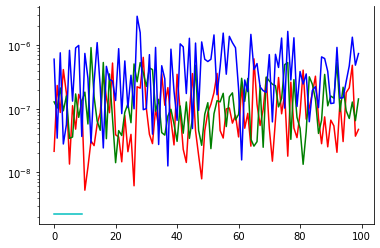

In [19]:
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.set_yscale('log')
plt.plot(ave_sq_error_e_s,color='r')
plt.plot(ave_sq_error_e,color='g')
plt.plot(ave_sq_error_c,color='b')
plt.plot(ave_sq_error_ideal,color='c')
plt.show()

In [18]:
import pandas as pd
pd.to_pickle(ave_sq_error_e_s, "ave_sq_error_e_s_3")#保存
pd.to_pickle(ave_sq_error_e, "ave_sq_error_e_3")
pd.to_pickle(ave_sq_error_c, "ave_sq_error_c_3")
pd.to_pickle(clt_opt_results_e_s,"clt_opt_results_e_s_3")
pd.to_pickle(clt_opt_results_e,"clt_opt_results_e_3")
pd.to_pickle(clt_opt_results_c,"clt_opt_results_c_3")

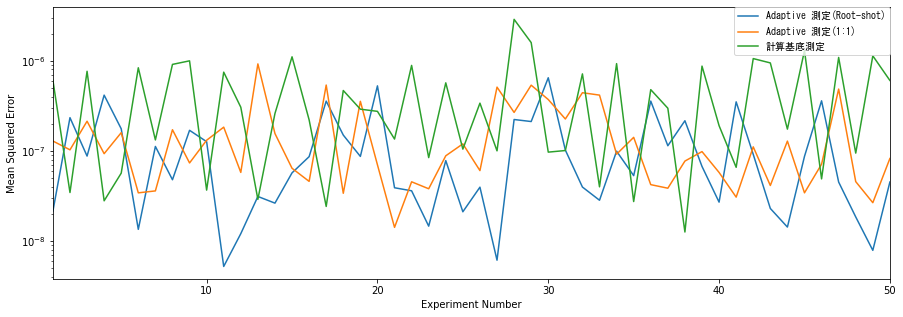

In [20]:
plt.figure(figsize=(15,5))
ax = plt.gca()
x=np.arange(1,51)
ax.set_yscale('log')
plt.xlabel("Experiment Number")
plt.ylabel("Mean Squared Error")
plt.xlim(1, 50)
plt.plot(x,ave_sq_error_e_s[0:50],label="Adaptive 測定(Root-shot)")
plt.plot(x,ave_sq_error_e[0:50],label="Adaptive 測定(1:1)")
plt.plot(x,ave_sq_error_c[0:50],label="計算基底測定")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=12,prop={"family":"MS Gothic"})
plt.show()

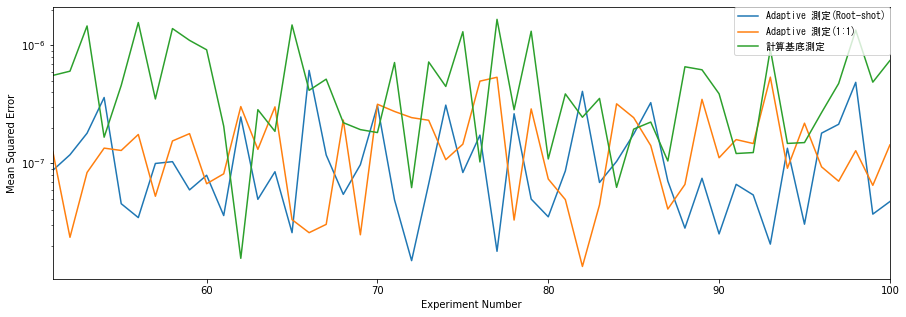

In [21]:
plt.figure(figsize=(15,5))
ax = plt.gca()
x=np.arange(51,101)
ax.set_yscale('log')
plt.xlabel("Experiment Number")
plt.ylabel("Mean Squared Error")
plt.xlim(51, 100)
plt.plot(x,ave_sq_error_e_s[50:100],label="Adaptive 測定(Root-shot)")
plt.plot(x,ave_sq_error_e[50:100],label="Adaptive 測定(1:1)")
plt.plot(x,ave_sq_error_c[50:100],label="計算基底測定")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=12,prop={"family":"MS Gothic"})
plt.show()

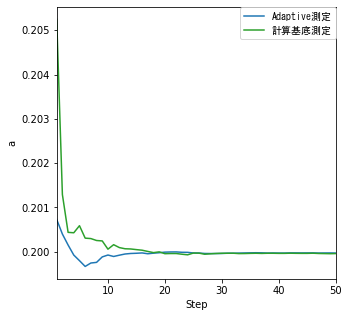

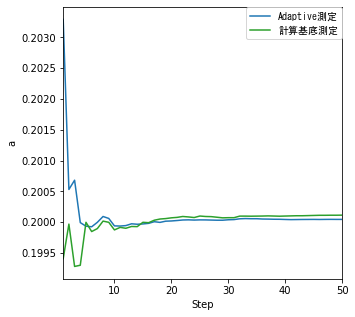

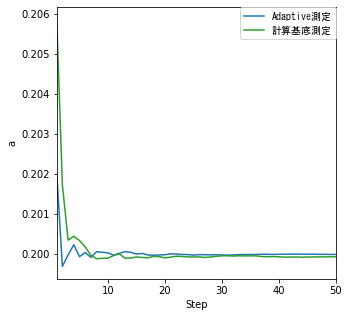

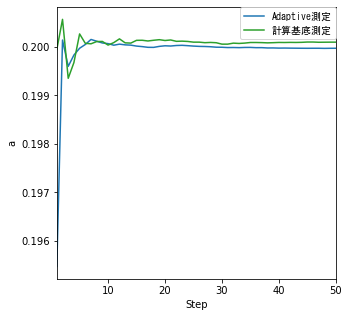

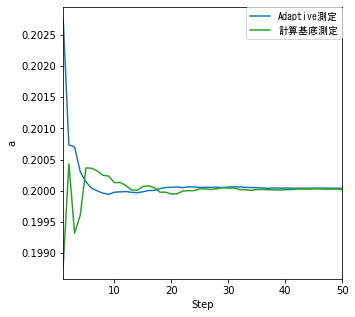

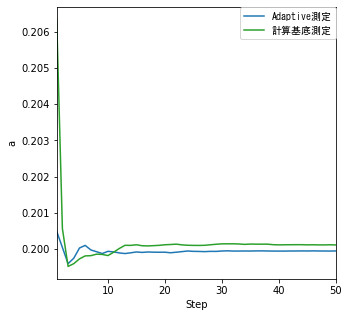

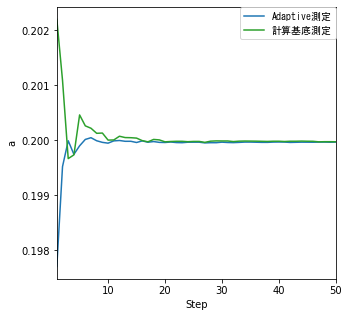

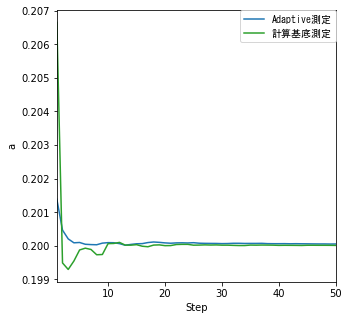

In [22]:
for m in range(8):
    plt.figure(figsize=(5,5))
    plt.xlim(1,50)
    x=np.arange(1,51)
    plt.xlabel("Step")
    plt.ylabel("a")
    plt.plot(x,clt_opt_results_e_s[m][1:101:2],color="tab:blue",label="Adaptive測定")
    plt.plot(x,clt_opt_results_c[m],color="tab:green",label="計算基底測定")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=12,prop={"family":"MS Gothic"})
    plt.show()

In [6]:
#読み込み
import pandas as pd
ave_sq_error_e_s=pd.read_pickle("ave_sq_error_e_s_3")
ave_sq_error_e=pd.read_pickle("ave_sq_error_e_3")
ave_sq_error_c=pd.read_pickle("ave_sq_error_c_3")

In [12]:
import numpy as np
print(np.average(ave_sq_error_e_s))
print(np.average(ave_sq_error_e))
print(np.average(ave_sq_error_c))

1.2717920931753798e-07
1.6380834064206754e-07
5.207027349293855e-07
aa


In [18]:
import pandas as pd
import numpy as np
ave_sq_error_e_s=pd.read_pickle("ave_sq_error_e_s_3")
ave_sq_error_e=pd.read_pickle("ave_sq_error_e_3")
ave_sq_error_c=pd.read_pickle("ave_sq_error_c_3")
print("Root分割の平均二乗誤差の平均は")
print(np.average(ave_sq_error_e_s))
print("1:1分割の平均二乗誤差の平均は")
print(np.average(ave_sq_error_e))
print("計算基底測定の平均二乗誤差の平均は")
print(np.average(ave_sq_error_c))

Root分割の平均二乗誤差の平均は
1.2717920931753798e-07
1:1分割の平均二乗誤差の平均は
1.6380834064206754e-07
計算基底測定の平均二乗誤差の平均は
5.207027349293855e-07
